<a href="https://colab.research.google.com/github/DrNelsonJatel/Testing-Social-Network-Metrics/blob/main/SNA_metrics_correlation_heatmap_standardized_betas_RM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

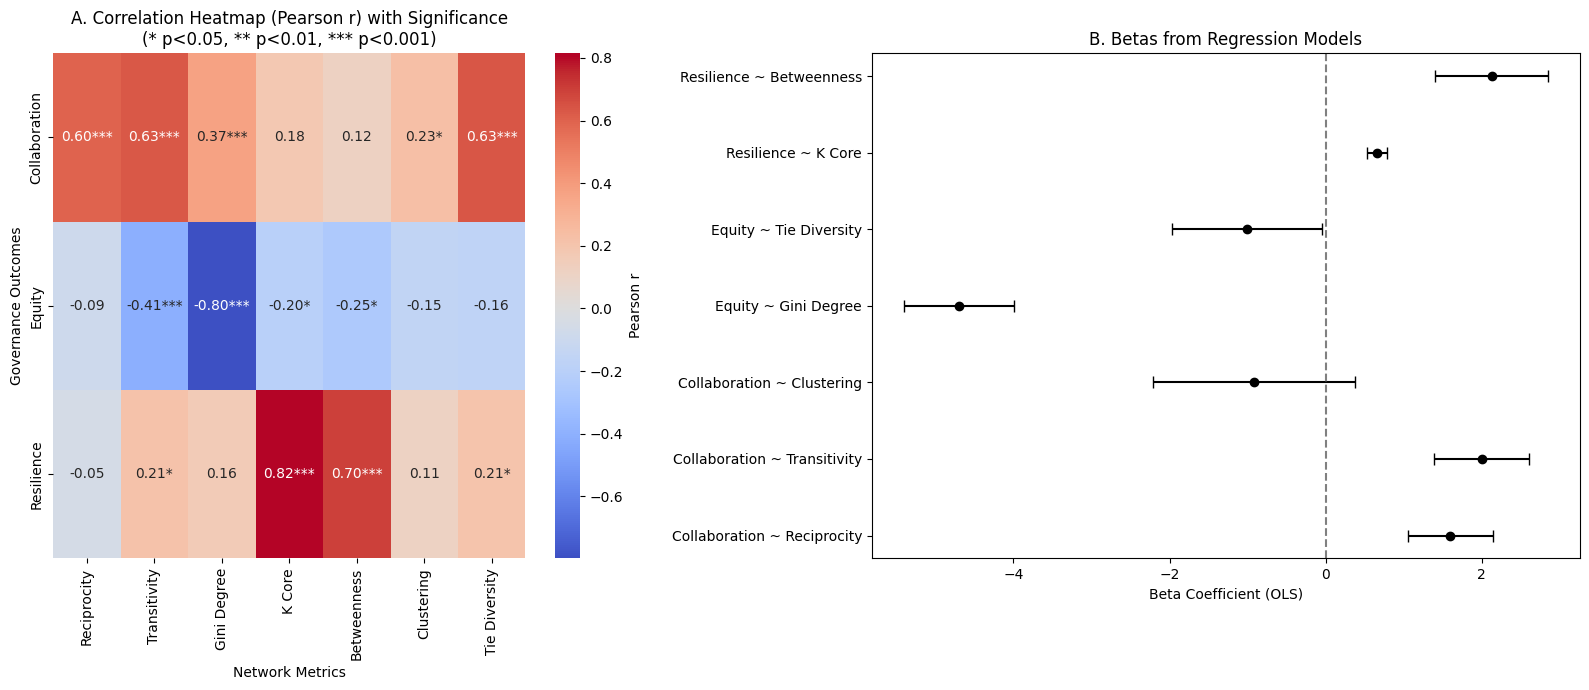

In [13]:
# -------------------------
# IMPORTS
# -------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import statsmodels.api as sm

# -------------------------
# LOAD & CLEAN DATA
# -------------------------
df = pd.read_excel("/content/final_extended_synthetic_governance_dataset.xlsx")
df.columns = (df.columns
              .str.replace('\xa0', ' ')
              .str.strip()
              .str.replace(' ', '_'))

# -------------------------
# DEFINE VARIABLES
# -------------------------
governance_outcomes = ["Collaboration_Score", "Equity_Score", "Resilience_Score"]
sna_metrics = ["Reciprocity", "Transitivity", "Gini_Degree",
               "K_Core", "Betweenness_Centrality", "Clustering_Coefficient", "Tie_Diversity"]

pretty_labels = {
    "Reciprocity": "Reciprocity",
    "Transitivity": "Transitivity",
    "Gini_Degree": "Gini Degree",
    "K_Core": "K Core",
    "Betweenness_Centrality": "Betweenness",
    "Clustering_Coefficient": "Clustering",
    "Tie_Diversity": "Tie Diversity"
}

regression_models = {
    "Collaboration_Score": ["Reciprocity", "Transitivity", "Clustering_Coefficient"],
    "Equity_Score": ["Gini_Degree", "Tie_Diversity"],
    "Resilience_Score": ["K_Core", "Betweenness_Centrality"]
}

# -------------------------
# PAIRWISE CORRELATIONS
# -------------------------
corr_matrix = pd.DataFrame(index=governance_outcomes, columns=sna_metrics)
p_matrix = corr_matrix.copy()

for outcome in governance_outcomes:
    for metric in sna_metrics:
        r, p = pearsonr(df[outcome], df[metric])
        corr_matrix.loc[outcome, metric] = r
        p_matrix.loc[outcome, metric] = p

def significance_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

annot_matrix = corr_matrix.copy().astype(str)
for i in corr_matrix.index:
    for j in corr_matrix.columns:
        star = significance_stars(p_matrix.loc[i, j])
        annot_matrix.loc[i, j] = f"{corr_matrix.loc[i, j]:.2f}{star}"

# -------------------------
# OLS REGRESSIONS
# -------------------------
betas = {}
errors = {}

for outcome, predictors in regression_models.items():
    X = df[predictors]
    X = sm.add_constant(X)
    y = df[outcome]
    model = sm.OLS(y, X).fit()
    for predictor in predictors:
        beta = model.params[predictor]
        ci_low, ci_high = model.conf_int().loc[predictor]
        err = (ci_high - ci_low) / 2
        if predictor not in betas:
            betas[predictor] = [np.nan, np.nan, np.nan]
            errors[predictor] = [np.nan, np.nan, np.nan]
        idx = governance_outcomes.index(outcome)
        betas[predictor][idx] = beta
        errors[predictor][idx] = err

# -------------------------
# PLOT COMBINED FIGURE
# -------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 7), gridspec_kw={'width_ratios': [1,1.2]})

# Heatmap
sns.heatmap(
    corr_matrix.astype(float), annot=annot_matrix, fmt="", cmap='coolwarm', center=0,
    cbar_kws={'label': 'Pearson r'}, ax=axes[0],
    xticklabels=[pretty_labels[x] for x in corr_matrix.columns],
    yticklabels=[x.replace('_Score','') for x in corr_matrix.index]
)
axes[0].set_title("A. Correlation Heatmap (Pearson r) with Significance\n(* p<0.05, ** p<0.01, *** p<0.001)")
axes[0].set_ylabel("Governance Outcomes")
axes[0].set_xlabel("Network Metrics")

# Forest plot
y_locs, y_labels, current_y = [], [], 0
for i, outcome in enumerate(governance_outcomes):
    for predictor in betas.keys():
        beta = betas[predictor][i] if not np.isnan(betas[predictor][i]) else None
        err = errors[predictor][i] if not np.isnan(errors[predictor][i]) else None
        if beta is not None:
            axes[1].errorbar(beta, current_y, xerr=err, fmt='o', color='black', capsize=4)
            y_labels.append(f"{outcome.replace('_Score','')} ~ {pretty_labels[predictor]}")
            y_locs.append(current_y)
            current_y += 1
axes[1].set_yticks(y_locs)
axes[1].set_yticklabels(y_labels)
axes[1].axvline(0, color='gray', linestyle='--')
axes[1].set_xlabel("Beta Coefficient (OLS)")
axes[1].set_title("B. Betas from Regression Models")

plt.tight_layout()
plt.savefig("Combined_Heatmap_ForestPlot_FINAL_CLEANED.png", dpi=600, bbox_inches='tight')
plt.show()
